Loading a dataset

In [54]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

# class that defines and loads the kangaroo dataset
class MasksDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class
        self.add_class("dataset", 1, "without_mask")
        self.add_class("dataset", 2, "mask_weared_incorrect")
        self.add_class("dataset", 3, "with_mask")
        # define data locations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annotations/'
        # find all images
        for i, filename in enumerate(listdir(images_dir)):
            # extract image id
            # we want first 170 images to put in test set and rest in training set
            if is_train and i < 170:
                continue
            elif not is_train and i >= 170:
                continue
            image_id = filename[:-4]
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        names = list()
        for obj in root.findall('./object'):
            name = obj.find('name').text
            box = obj.find('bndbox')
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
            names.append(name)
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, names, width, height

    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, names, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index(names[i]))
        return masks, asarray(class_ids, dtype='int32')

    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

# train set
train_set = MasksDataset()
train_set.load_dataset(r'../data', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
test_set = MasksDataset()
test_set.load_dataset(r'../data', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 683
Test: 170


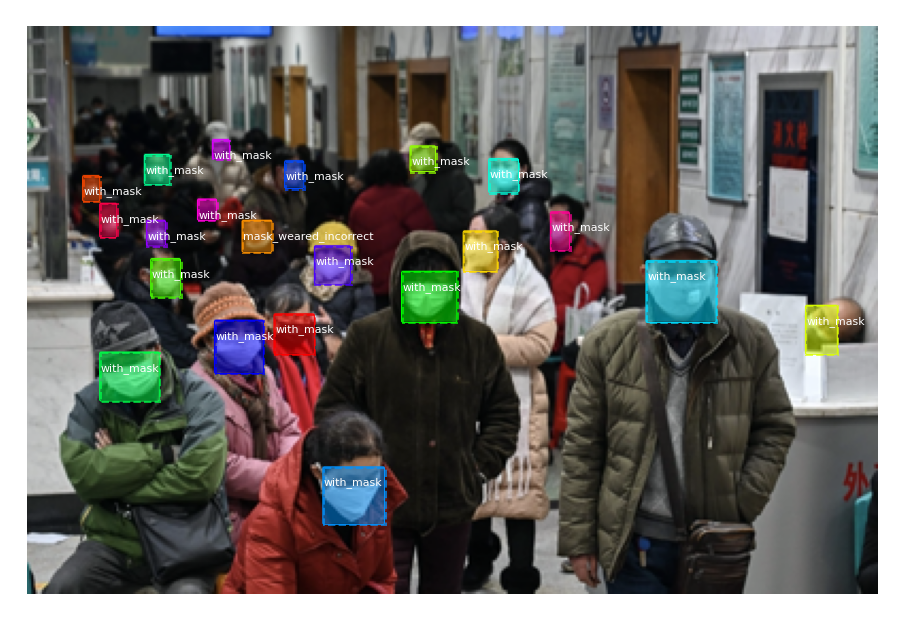

In [55]:
image_id = 177
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)